In [1]:
# Tendorflow imports
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

# Helper libraries
import math
import numpy as np
import matplotlib
matplotlib.use('PS') #prevent import error due to venv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

In [22]:
# Imports for dataset separation
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# Import for model testing and curves
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.calibration import calibration_curve
from sklearn.metrics import ConfusionMatrixDisplay

# Improve progress bar display
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm

In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# get the data into slices
data_images = []
data_labels = []
rel_img_path = '/content/drive/MyDrive/HiRISE-Net-master/map-proj/' # add path of folder to image name for later loading

In [5]:
other_counter=0
with open('labels-map-proj.txt','r') as labels:
  for line in labels:
    file_name, label = line.split(' ')
    if int(label)==0:
        other_counter += 1
    if int(label)==0 and other_counter>500:
        continue
    data_images.append(rel_img_path + file_name)
    data_labels.append(int(label))
len(data_images)

2302

In [70]:
# divide data into testing and training (total len 3820)
train_images, test_images, train_labels, test_labels = train_test_split(
    data_images, data_labels, test_size=0.15, random_state=666)
test_len = len(test_images)   # 573
train_len = len(train_images) # 3247
print(test_len,train_len)

346 1956


In [53]:
# label translations
class_labels = ['other','crater','dark_dune','streak',
                'bright_dune','impact','edge']

In [71]:
#convert image paths into numpy matrices
def parse_image(filename):
  img_obj = Image.open(filename)
  img = np.asarray(img_obj).astype(np.float32)
  #normalize image to 0-1 range
  img /= 255.0
  return img

train_images = np.array(list(map(parse_image, train_images)))
test_images = np.array(list(map(parse_image, test_images)))

In [72]:
# convert labels to one-hot encoding
def to_one_hot(label):
  encoding = [0 for _ in range(len(class_labels))]
  encoding[label] = 1
  return np.array(encoding).astype(np.float32)

train_labels = np.array(list(map(to_one_hot, train_labels)))
test_labels = np.array(list(map(to_one_hot, test_labels)))

In [73]:
# model.fit requires train data to be in the shape of [batch, imDim1, imDim2, numChannels]
# slap extra dimension on the end of train images so tf will be happy
train_images = np.reshape(train_images, (-1, 227, 227, 1)) #add 4th dim
train_labels = np.reshape(train_labels, (-1, 7))
test_images = np.reshape(test_images, (-1, 227, 227, 1))
test_labels = np.reshape(test_labels, (-1, 7))

In [11]:
# Define data augmentation parameters
# make a generator to train the model with
generator = ImageDataGenerator(
    rotation_range=10,       # Rotate images by 10 degrees
    width_shift_range=0.1,   # Shift images horizontally by 10% of the width
    height_shift_range=0.1,  # Shift images vertically by 10% of the height
    shear_range=0.1,         # Shear intensity (angle in counter-clockwise direction in radians)
    zoom_range=0.1,          # Zoom images by up to 10%
    horizontal_flip=True,    # Flip images horizontally
    vertical_flip=False)     # Don't flip images vertically

In [12]:
###             BUILD SHAPE OF THE MODEL              ###
model = tf.keras.Sequential([
    Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(227, 227, 1)),
    tf.keras.layers.BatchNormalization(),
    MaxPooling2D((2,2), strides=2),
    Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    MaxPooling2D((2,2), strides=2),
    Conv2D(256, (3,3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    MaxPooling2D((2,2), strides=2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Adding dropout for regularization
    Dense(256, activation='relu'),
    Dropout(0.5),  # Adding dropout for regularization
    tf.keras.layers.BatchNormalization(),
    Dense(7, activation='softmax')  # final layer with node for each classification
])

In [13]:
# specify loss and Stochastic Gradient Descent functions
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
###                 TRAIN THE MODEL                   ###
#specify training metadata
BATCH_SIZE = 32
steps_per_epoch = len(train_images) // BATCH_SIZE  # Number of batches per epoch
epochs = 20
print("About to train...")
# train the model on the training data
history = model.fit(generator.flow(train_images, train_labels, batch_size=BATCH_SIZE),
                    epochs=epochs,
                    validation_data=(test_images,test_labels))


About to train...
Epoch 1/20
62/62 [==============================] - 938s 15s/step - loss: 1.2600 - accuracy: 0.5578 - val_loss: 3.0874 - val_accuracy: 0.2341
Epoch 2/20
62/62 [==============================] - 895s 14s/step - loss: 0.9999 - accuracy: 0.6401 - val_loss: 3.1200 - val_accuracy: 0.2052
Epoch 3/20
62/62 [==============================] - 864s 14s/step - loss: 0.9881 - accuracy: 0.6360 - val_loss: 3.5756 - val_accuracy: 0.1618
Epoch 4/20
62/62 [==============================] - 858s 14s/step - loss: 0.8635 - accuracy: 0.6697 - val_loss: 3.1111 - val_accuracy: 0.2399
Epoch 5/20
62/62 [==============================] - 860s 14s/step - loss: 0.9519 - accuracy: 0.6457 - val_loss: 3.0971 - val_accuracy: 0.2601
Epoch 6/20
62/62 [==============================] - 879s 14s/step - loss: 0.8830 - accuracy: 0.6590 - val_loss: 2.7378 - val_accuracy: 0.1676
Epoch 7/20
62/62 [==============================] - 856s 14s/step - loss: 0.8747 - accuracy: 0.6626 - val_loss: 3.1596 - val_accur

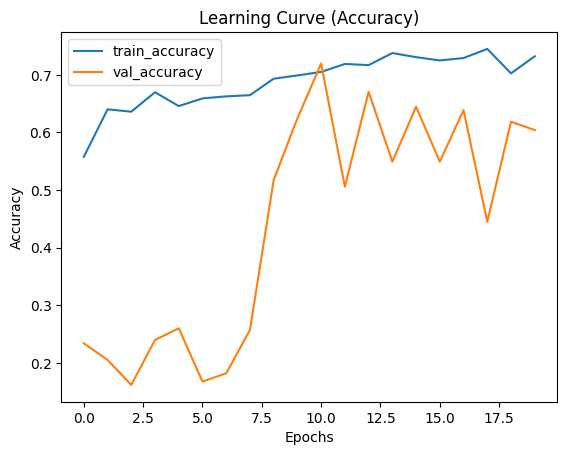

In [38]:
%matplotlib inline
# Plot Learning Curve (Accuracy)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve (Accuracy)')
plt.legend()
plt.show()

In [16]:
# Predicting for test imgs
test_pred = np.argmax(model.predict(test_images),axis=1)

11/11 [==============================] - 37s 3s/step


In [74]:
test_pred = model.predict(test_images)


11/11 [==============================] - 38s 3s/step


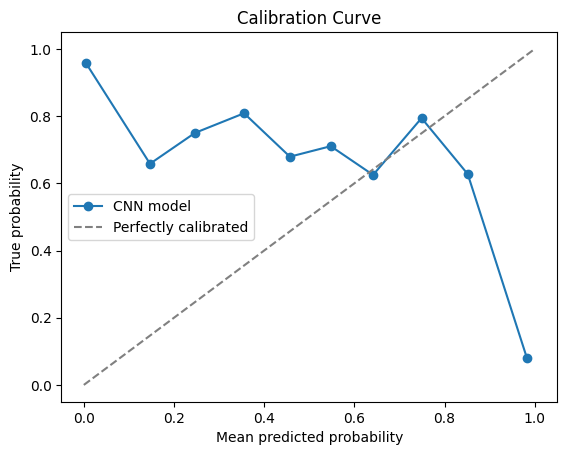

In [79]:
# Calculate true probabilities (mean predicted probabilities for each bin)
test_labels1, test_pred1 = calibration_curve(test_labels.flatten(), test_pred.flatten(), pos_label=0, n_bins=10)

# Plot Calibration Curve
plt.plot(test_pred1, test_labels1, marker='o', label='CNN model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('True probability')
plt.title('Calibration Curve')
plt.legend()
plt.show()

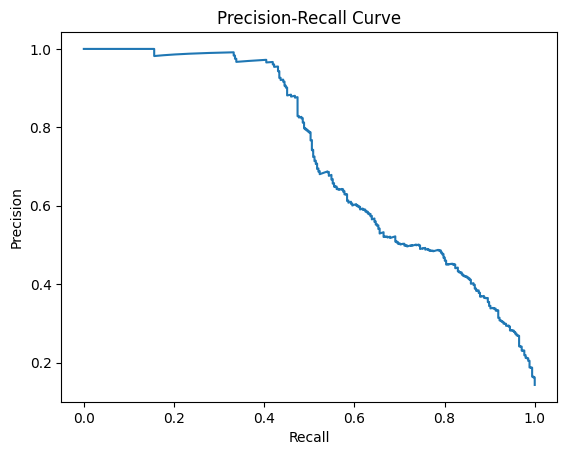

In [83]:
# Get precision and recall values
precision, recall, _dash_ = precision_recall_curve(test_labels.flatten(), test_pred.flatten())

# Plot Precision-Recall Curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [84]:
###             EVALUATE MODEL ACCURACY               ###
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print("Final loss was {}.\nAccuracy of model was {}".format(test_loss,test_accuracy))

print("Model Scores:")


11/11 [==============================] - 37s 3s/step - loss: 1.5514 - accuracy: 0.6040
Final loss was 1.5514302253723145.
Accuracy of model was 0.6040462255477905
Model Scores:


In [98]:
# Calculate accuracy
accuracy = accuracy_score(np.argmax(test_labels,axis=1), np.argmax(test_pred,axis=1))

# Calculate precision, recall, and F1 score
precision = precision_score(np.argmax(test_labels,axis=1), np.argmax(test_pred,axis=1), average='macro')  # You can change average to 'micro' or 'weighted' if needed
recall = recall_score(np.argmax(test_labels,axis=1), np.argmax(test_pred,axis=1), average='macro')
f1 = f1_score(np.argmax(test_labels,axis=1), np.argmax(test_pred,axis=1), average='macro')

# Calculate confusion matrix
conf_matrix = confusion_matrix(np.argmax(test_labels,axis=1), np.argmax(test_pred,axis=1))

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.6040462427745664
Precision: 0.4234012446989235
Recall: 0.38355067927852743
F1 Score: 0.32256952132069944
Confusion Matrix:
 [[ 23  53   0   0   0   3]
 [  2  54   0   0   0   0]
 [  8  40   3   0   0   5]
 [  1   3   0   0   0   0]
 [ 10   9   0   0   0   2]
 [  0   0   1   0   0 129]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of labels (2).

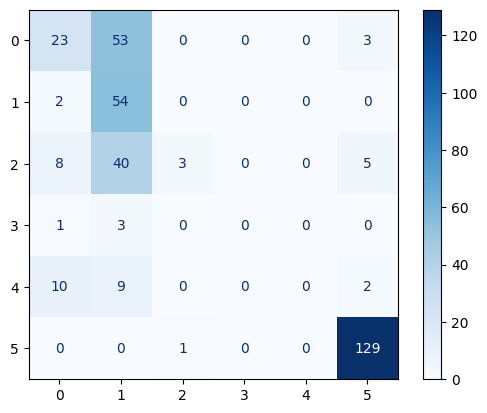

In [97]:
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=np.arange(7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [21]:
model.save("model.keras")